## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [100]:
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer


from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
# load in the data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('Test.csv')

train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


# Explore the dataset

In [39]:
train_data.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [40]:
train_data.purchase.value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [41]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [74]:
def calc_irr(df):
    """
    Calculate the IRR: Incremental Response Rate
    
    Args:
        df: the cleaned pandas dataframe containing the experiment results
    Return
        the IRR (float)
    """
    # How many users received the promo?
    treatment_cust = df.Promotion.eq('Yes').sum()
    # How many in the control group?
    control_cust = df.Promotion.eq('No').sum()
    
    # How many received the promo and made the purhcase?
    treatment_purchase = df[(df.Promotion == 'Yes') & (df.purchase == 1)].shape[0]
    
    # How many of the control made the purchase?
    control_purchase = df[(df.Promotion == 'No') & (df.purchase == 1)].shape[0]
    
    # Hyp testing
    # Whether they purchase or not in a Bernoulli RV 0, 1, mean is p(1-p)
    # where p is probability of purchase (purchase rate)
    # Under the null the treatment purchase rate is same as control purchase rate
    p_null = control_purchase/control_cust
    p_alt = treatment_purchase/treatment_cust
    # Under the null the std error of the difference in rates is
    se_null = np.sqrt(p_null*(1.0-p_null)*(1.0/control_cust + 1.0/treatment_cust))
    irr = p_alt - p_null
    z = irr/se_null
    # 1 sided since interested in p_alt > p_null (another way is norm.sf (survival func: 1-cdf))
    pval = norm.sf(z)
    print(f'p_null was {p_null*100:.2f}% and p_alt was {p_alt*100:.2f}%')
    print(f'The irr is {irr} (or {irr*100:.2f}%), z-value is {z} and the p-val {pval}')
    
    return irr, pval

In [75]:
calc_irr(train_data)

p_null was 0.76% and p_alt was 1.70%
The irr is 0.009454547819772702 (or 0.95%), z-value is 15.862830106831561 and the p-val 5.730531346507274e-57


(0.009454547819772702, 5.730531346507274e-57)

We see that there was an increased response in the experimental group that received the ad campaign, and it was a statistically signicant increase.

In [76]:
def calc_nir(df, unit_price=10, promo_cost=0.15):
    """
    Calculate the NIR: Net Incremental Revenue
    
    Args:
        df: the cleaned pandas dataframe containing the experiment results
    Return
        the NIR (float)
    """
    # How many users received the promo?
    treatment_cust = df.Promotion.eq('Yes').sum()
    
    # How many received the promo and made the purhcase?
    treatment_purchase = df[(df.Promotion == 'Yes') & (df.purchase == 1)].shape[0]
    
    # How many of the control made the purchase?
    control_purchase = df[(df.Promotion == 'No') & (df.purchase == 1)].shape[0]
    
    print(f'There are {treatment_cust} customers in the treatment group.')
    print(f'{treatment_purchase} customers in the treatment group made a purchase.')
    print(f'{control_purchase} customers in the control group made a purchse.')

    # How much did net did we make in the treatment group vs control group
    nir = ((unit_price*treatment_purchase)-(promo_cost*treatment_cust))-(unit_price*control_purchase)
    print(f'The NIR was {nir}')
    return nir

In [77]:
calc_nir(train_data)

There are 42364 customers in the treatment group.
721 customers in the treatment group made a purchase.
319 customers in the control group made a purchse.
The NIR was -2334.5999999999995


-2334.5999999999995

So even though there was an increased response, the net increase in revenue was actually negative; we spent more money than we gained.This motivates the need to target the ad to specific users rather than
send it out to all of them in order to increase the IRR and NIR. We need to target a subset of the userbase that responds strongly enough to the promotion for the cost to be worthwhile

We also see the dataset is quite imbalanced. We have have a few hundred puchases in tens of thousands of customers.

In [5]:
train_data.shape, test_data.shape

((84534, 10), (41650, 10))

# Linear Regression

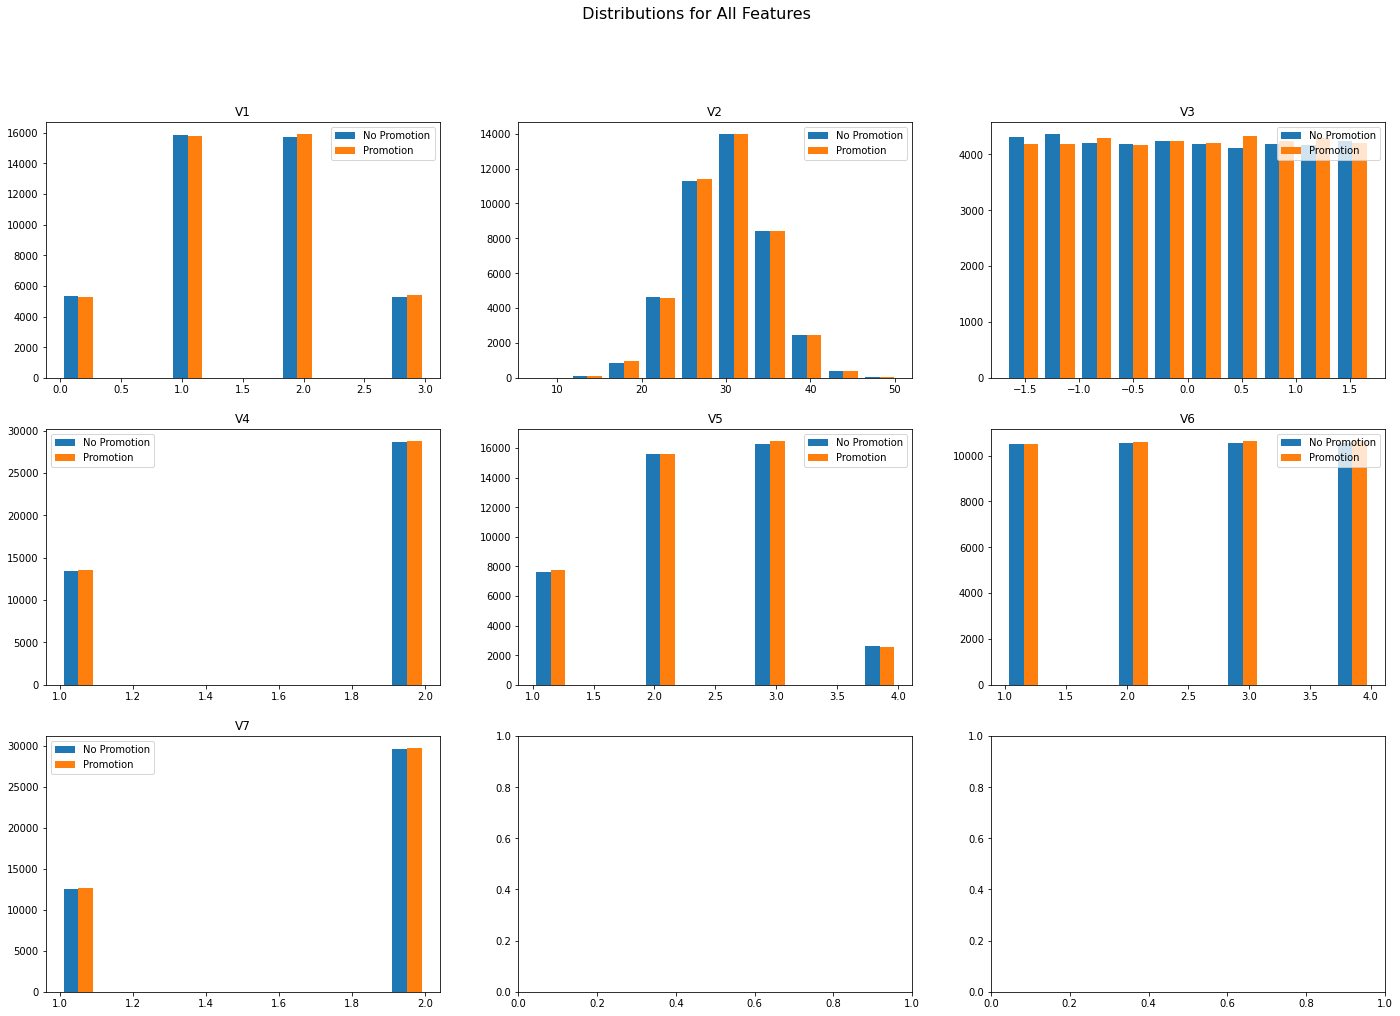

In [90]:
features = [col for col in train_data if col.startswith('V')]


# Compare the control and experimental marginal distributions
# for each feature
fig, axs = plt.subplots(3, 3)
for i, feature in enumerate(features):
    no_promote = train_data[train_data['Promotion'] == 'No'][feature]
    promote = train_data[train_data['Promotion'] == 'Yes'][feature]
    ax = axs[i // 3][i % 3]
    ax.hist([no_promote, promote])
    ax.legend(["No Promotion",  "Promotion"])
    ax.set_title(feature)
fig.set_size_inches(24, 16)
plt.suptitle(" Distributions for All Features", fontsize=16)
plt.show()

It seems that maybe V1, V2, V5, V6, V7 could be categorical. V2, V3 are not categorical. V2 needs to be standardized to a standard normal, and it looks like doing so would not result in much information loss. V3 is uniform
and already within range -1.5 to 1.5, so we can leave it

In [92]:
def prep_features(data):
    data = data.copy()
    
    # One hot for columns that seem to be categorical
    cat_cols = ['V1', 'V4', 'V5', 'V6', 'V7'] 
    cats = pd.get_dummies(data.loc[:, cat_cols], drop_first=True, columns=cat_cols)
    
    # Standard Scalar for the other features
    data = data.drop(cat_cols, axis=1)

    data[['V2']] =  StandardScaler().fit_transform(data[['V2']])
    
    # Concat
    data = pd.concat([data, cats], axis=1)
    return data

In [93]:
# We will run a regression over the control and treatment groups sepately to see how the coefficients differ for each group
X_promo = train_data[(train_data.Promotion == 'Yes')][features]
y_promo = train_data[(train_data.Promotion == 'Yes')].purchase
X_control = train_data[(train_data.Promotion == 'No')][features]
y_control = train_data[(train_data.Promotion == 'No')].purchase
X_promo_clean = prep_features(X_promo)
X_control_clean = prep_features(X_control)

In [94]:
X_control_clean.columns

Index(['V2', 'V3', 'V1_1', 'V1_2', 'V1_3', 'V4_2', 'V5_2', 'V5_3', 'V5_4',
       'V6_2', 'V6_3', 'V6_4', 'V7_2'],
      dtype='object')

In [95]:
lr_control = LinearRegression()
lr_promo = LinearRegression()
lr_control.fit(X_control_clean, y_control)
lr_promo.fit(X_promo_clean, y_promo)

LinearRegression()

In [96]:
print(lr_control.coef_)

[ 7.57885592e-06  7.11915380e-04  1.18036354e-03 -9.64160685e-04
 -3.35416110e-04  4.35380579e-04  8.33197828e-04  6.24762670e-04
  1.37358327e-03  1.32619040e-03  3.64626481e-04  6.61281093e-05
  8.97767368e-04]


In [97]:
coeffs_df = pd.DataFrame(data={'no promotion': lr_control.coef_, 'promotion': lr_promo.coef_}, index=X_control_clean.columns)

[Text(0.5, 0, 'Feature'), Text(0, 0.5, 'Coefficient')]

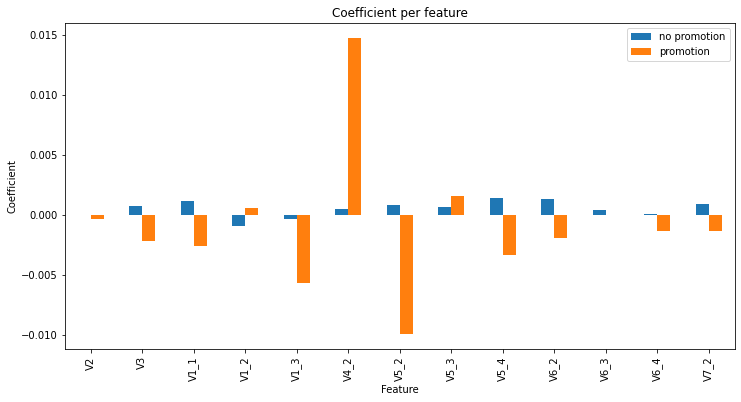

In [98]:
ax = coeffs_df.plot.bar(stacked=False, figsize=(12,6), title='Coefficient per feature')
# set labels for both axes
ax.set(xlabel='Feature', ylabel='Coefficient')

It appears that the greatest difference is between V4_2, V5_2, V2_3

# RandomForest

In [101]:
#make new feature response where promotion is yes and purchase is also 1 (yes)
train_data['response'] = np.where((train_data.Promotion == 'Yes') & (train_data.purchase == 1), 1, 0)

In [102]:
train_data[train_data['response'] == 1]

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
107,162,Yes,1,1,33.030562,-0.732194,2,1,1,1,1
328,503,Yes,1,3,31.760033,1.518828,2,1,2,2,1
352,534,Yes,1,2,17.512709,1.259095,2,3,4,2,1
383,580,Yes,1,1,31.043736,-1.338239,2,1,2,1,1
443,661,Yes,1,2,26.775416,1.432250,2,3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...
84299,125803,Yes,1,3,35.496938,-0.039572,2,4,2,2,1
84300,125804,Yes,1,1,34.289793,0.047006,2,2,1,1,1
84314,125828,Yes,1,2,33.966419,1.605406,2,1,3,2,1
84388,125954,Yes,1,2,31.100225,-1.165083,2,3,2,1,1


In [104]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data[features], train_data['response'], test_size=0.2, random_state=42)

In [105]:
# Dataset it imbalance: upsample
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)

In [123]:
class RegressionTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X['V2'].to_numpy().reshape(-1, 1))
        return self

    def transform(self, X):
        cats = pd.get_dummies(X.loc[:, self.cat_cols], drop_first=True, columns=self.cat_cols)
        X = X.drop(self.cat_cols, axis=1)
        
        # Don't noralize V3 as it's actually uniform
        X['V2'] = self.scaler.transform(X['V2'].to_numpy().reshape(-1, 1))[:, 0]
        X = pd.concat([X, cats], axis=1)
        return X

In [110]:
def train_pipeline(X_train, y_train):

    clf = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=1000)

    pipeline = Pipeline([
        ('featurizer', RegressionTransformer()),
        ('rf', clf)
    ]);
    pipeline.fit(X_train, y_train)
    return pipeline

In [111]:
# Random forest
# rf_pipe = make_pipeline(StandardScalar(), RandomForestClassifier())
# rf_pipe.fit(X_train, y_train)  # apply scaling on training data
rf_pipe = train_pipeline(X_train_upsamp, Y_train_upsamp)  # apply scaling on training data
# clf.fit(X_train_upsamp, Y_train_upsamp)

In [112]:
# Score on test
rf_pipe.score(X_valid, Y_valid)  # apply scaling on testing data, without leaking training data

0.6531022653338854

In [124]:
rf_pipe.predict(X_valid)

array([0, 1, 0, ..., 1, 1, 1])

In [113]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    y_pred=rf_pipe.predict(df)
    promotion = []
    for pred in y_pred:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    
    return promotion

In [114]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0192.

Your nir with this strategy is 286.65.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01923708283229737, 286.6500000000001)

## XGBoost

In [129]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.175,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.3,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[21:48:46] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74629	validation_1-auc:0.56087
[1]	validation_0-auc:0.77672	validation_1-auc:0.56292
[2]	validation_0-auc:0.79425	validation_1-auc:0.55668
[3]	validation_0-auc:0.79989	validation_1-auc:0.56249
[4]	validation_0-auc:0.82484	validation_1-auc:0.57844
[5]	validation_0-auc:0.83684	validation_1-auc:0.57690
[6]	validation_0-auc:0.85561	validation_1-auc:0.57172
[7]	validation_0-auc:0.86349	validation_1-auc:0.58159
[8]	validation_0-auc:0.87377	validation_1-auc:0.57987
[9]	validation_0-auc:0.87895	validation_1-auc:0.57656
[10]	validation_0-auc:0.88772	validation_1-auc:0.57869
[11]	validation_0-auc:0.88765	validation_1-auc:0.57908
[12]	validation_0-auc:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.175, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

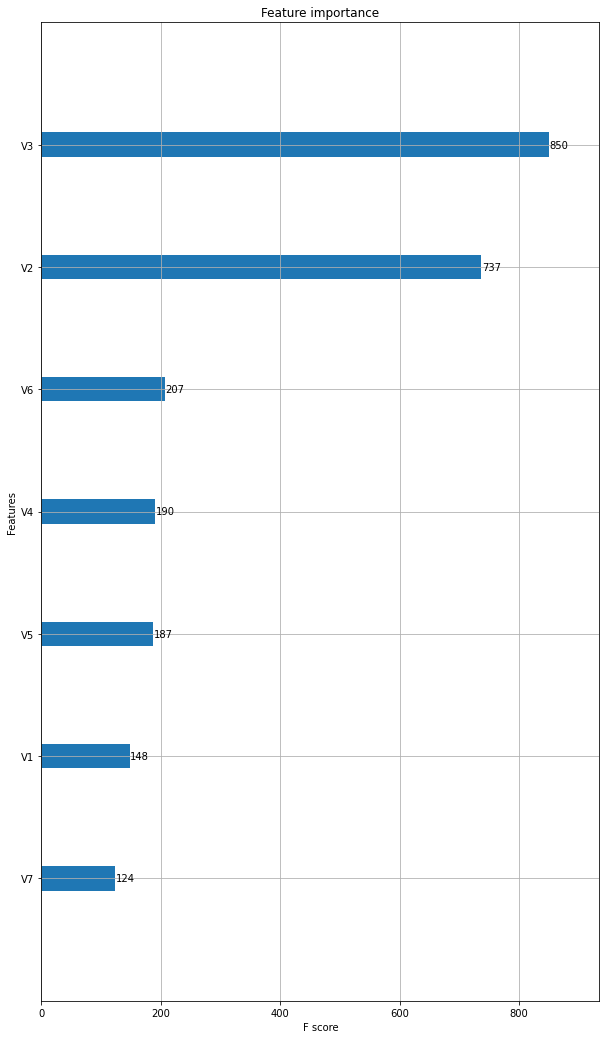

In [136]:
fig, ax = plt.subplots(figsize=(10, 18));
from xgboost import plot_importance

xgb.plot_importance(model, ax=ax);


In [131]:
def promotion_strategy1(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    y_pred=model.predict(df)
    promotion = []
    for pred in y_pred:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    
    return promotion

In [132]:
test_results(promotion_strategy1)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0214.

Your nir with this strategy is 313.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.021353518813767878, 313.25)